# Phenograph clustering

This notebook was retrieved from GitHub as [model201710_model_analyse_single_cells.ipynb](https://github.com/BodenmillerGroup/3D_IMC_publication/blob/main/Python/scripts/single_cell_analysis/model201710_model_analyse_single_cells.ipynb). It was modified to execute phenograph clustering only.

At the end of this document, after manually re-coding the cluster labels to match the ones in the publication, the number of clusters was further reduced, which is not part of the original publication.


In [2]:
## Imports
import scanpy as sc
import numpy as np
import pandas as pd
import phenograph
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
## File paths
input_base = "../../data/Kuett_2022/MainHer2BreastCancerModel/"
measurements = input_base + 'model201710_mean_intensities.csv'
lable_annotation = input_base + 'model201710_labels_area.csv'

In [4]:
## Load data
adata = sc.read_csv(measurements)
extra_annotation = pd.read_csv(lable_annotation)
adata.obs['cell_labels'] = list(extra_annotation['label'])
adata.obs['cell_labels'] = adata.obs['cell_labels'].astype('category')
adata.obs['cell_volume'] = list(extra_annotation['area'])
adata.obs['cell_volume'] = adata.obs['cell_volume'].astype('int64')

In [9]:
adata ## data structure

AnnData object with n_obs × n_vars = 108486 × 25
    obs: 'cell_labels', 'cell_volume'

In [4]:
## Range normalization to the 99th percentile
## across all cells, for each channel separately
max_each_var = np.percentile(adata.X, 99, axis = 0)
min_each_var = np.min(adata.X,0)
range_var = max_each_var - min_each_var
adata.X = adata.X - min_each_var
adata.X = np.divide(adata.X, range_var)
adata.X[adata.X>1] = 1

sc.pp.neighbors(adata, n_neighbors=10,random_state = 111)
sc.tl.umap(adata,random_state = 111)
#adata.write(results_file)

/home/gesa/.py_venv/phenograph/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
adata ## data structure

AnnData object with n_obs × n_vars = 108486 × 25
    obs: 'cell_labels', 'cell_volume'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [86]:
## Save data (temporary)
outfile = "../../data/temp/Kuett_2022_phenotyping_before_phenograph.h5ad"
adata.write(outfile)

In [5]:
## Load data if previously saved
infile = "../../data/temp/Kuett_2022_phenotyping_before_phenograph.h5ad"
adata = sc.read(infile)
adata

AnnData object with n_obs × n_vars = 108486 × 25
    obs: 'cell_labels', 'cell_volume'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

In [45]:
## Phenograph clustering
## Since this is not replicable (despite seed)
## skip this step and load the results below
communities, graph, Q = phenograph.cluster(adata.X, k=10, primary_metric= 'manhattan', seed = 10)
print(np.unique(communities))

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 49.71676182746887 seconds
Jaccard graph constructed in 3.3068535327911377 seconds
Wrote graph to binary file in 0.3313634395599365 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.867816
After 3 runs, maximum modularity is Q = 0.869564
Louvain completed 23 runs in 28.383280038833618 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 82.40377998352051 seconds
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36]


In [46]:
np.unique(communities) ## cluster labels

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36])

In [47]:
## Recode cluster 0 to a new cluster number
## for visualization?
largest = max(np.unique(communities))+1
communities = [largest if x == 0 else x for x in communities]
adata.obs['phenograph'] = pd.Categorical(communities)

In [48]:
np.unique(communities) ## cluster labels

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

In [51]:
adata ## data structure

AnnData object with n_obs × n_vars = 108486 × 25
    obs: 'cell_labels', 'cell_volume', 'phenograph'
    uns: 'neighbors', 'umap', 'dendrogram_phenograph'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [52]:
## Save cluster labels to file
outfile = input_base + 'model201710_cluster_labels_phenograph.csv'
adata.obs[['cell_labels', 'phenograph']].to_csv(outfile, index=False)

In [ ]:
## Load data from file if previously saved
## to conserve cluster labels
outfile = input_base + 'model201710_cluster_labels_phenograph.csv'
adata.obs['phenograph'] = pd.read_csv(outfile)['phenograph'].values # TODO - merge instead

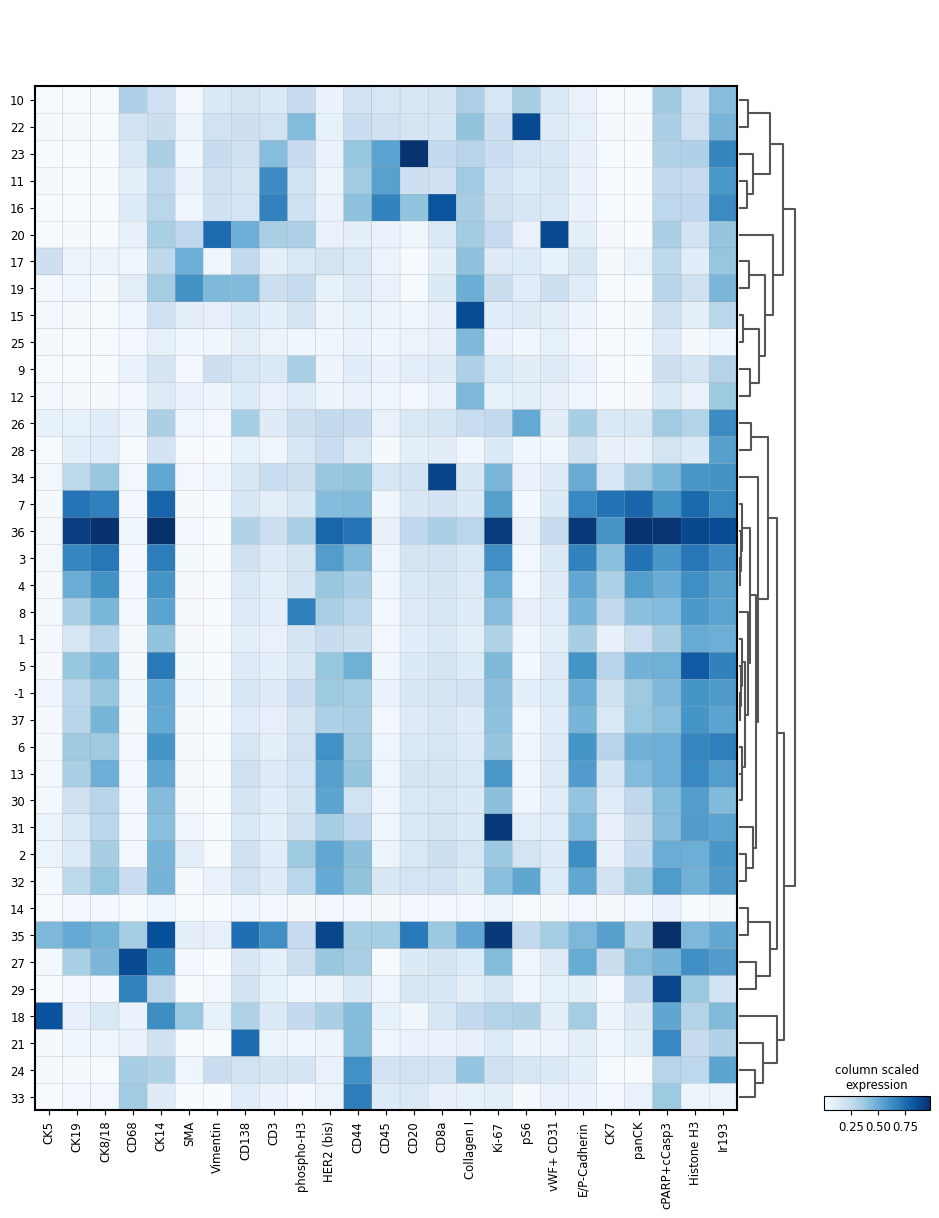

In [68]:
## Plot (as in Fig. 3a)
sc.tl.dendrogram(adata, groupby='phenograph') ## prerequisite for plotting
sc.pl.matrixplot(adata,adata.var_names, 'phenograph', dendrogram=True, cmap='Blues', 
                 colorbar_title='column scaled\nexpression') #, save = '_model201710_median_expression_phenograph.pdf' ) #standard_scale='var', 

In [79]:
## Get number of cells per cluster (as in Fig. 3a)
counts = adata.obs['phenograph'].groupby(adata.obs['phenograph']).count()
counts

/tmp/ipykernel_129424/3671556161.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata.obs['phenograph'].groupby(adata.obs['phenograph']).count()


phenograph
-1       129
 1     10055
 2      8992
 3      7392
 4      7278
 5      6664
 6      5479
 7      5319
 8      4025
 9      3935
 10     3810
 11     3202
 12     3042
 13     2462
 14     2151
 15     2035
 16     2014
 17     1992
 18     1859
 19     1721
 20     1663
 21     1232
 22     1109
 23     1012
 24      941
 25      904
 26      841
 27      837
 28      687
 29      574
 30      537
 31      389
 32      353
 33      233
 34      109
 35       69
 36       61
 37    13379
Name: phenograph, dtype: int64

In [5]:
## Re-code labels from here to match the original labels
label_recode = {
    -1:7, 1:3, 2:2, 3:11, 4:12, 5:4, 6:34, 7:1, 8:6, 9:9,
    10:-1, 11:13, 12:14, 13:20, 14:16, 15:22, 16:18, 17:15, 18:19, 19:17,
    20:21, 21:23, 22:8, 23:25, 24:26, 25:27, 26:29, 27:28, 28:24, 29:30,
    30:37, 31:31, 32:32, 33:33, 34:35, 35:36, 36:1, 37:5 }

adata_recoded = adata.copy()
adata_recoded.obs['phenograph'] = adata_recoded.obs['phenograph'].map(label_recode)
adata_recoded.obs['phenograph'] = pd.Categorical(adata_recoded.obs['phenograph'])
## Plot
sc.tl.dendrogram(adata_recoded, groupby='phenograph')
sc.pl.matrixplot(adata_recoded, adata_recoded.var_names, 'phenograph', dendrogram=True, cmap='Blues', 
                 colorbar_title='column scaled\nexpression')

KeyError: 'phenograph'

Kuett et al. (2021) described some spatial patterns they observed by eye:
- "clear tendency of CD45+CD3+ T cells (cluster 13 and 18) to cluster around the vWF+CD31+ endothelial cells (cluster 21)"
- "spatial separation of different subsets of CD68+ cells (clusters 30 and 28)"

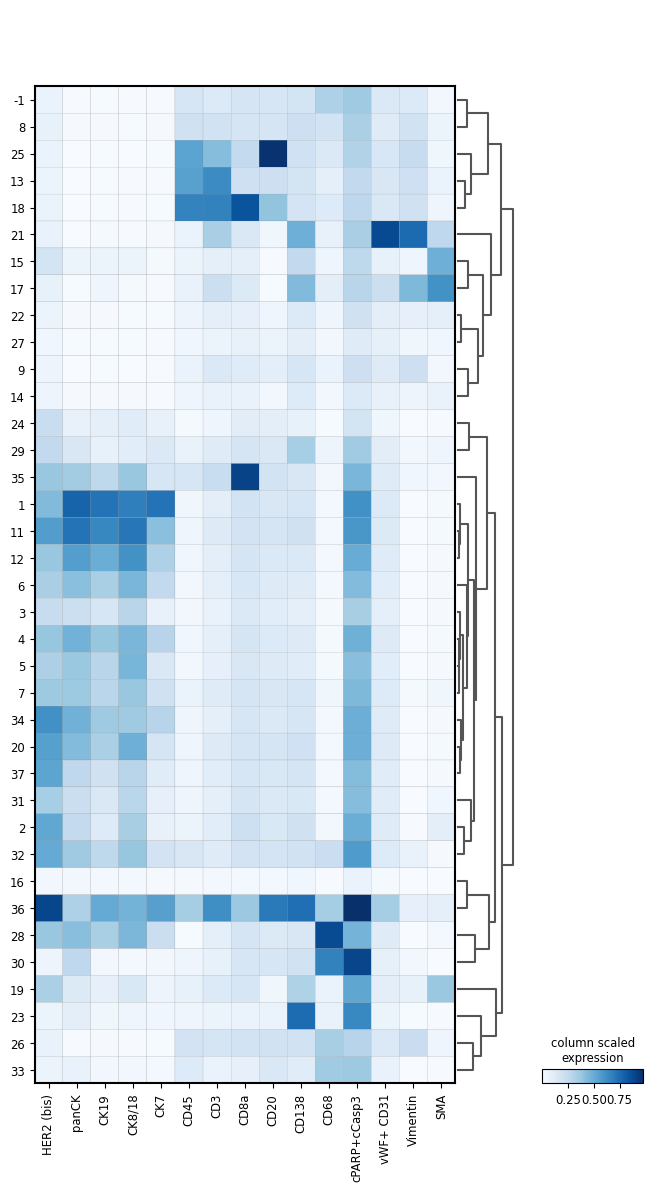

In [8]:
## Plot heatmap using just cell type markers
ct_markers = ['HER2 (bis)', 'panCK', 'CK19', 'CK8/18', 'CK7', #'CK5',
              'CD45', 'CD3', 'CD8a', 'CD20', 'CD138', 'CD68',
              'cPARP+cCasp3', 'vWF+ CD31', 'Vimentin', 'SMA']
for x in ct_markers:
    if x not in adata_recoded.var_names:
        print(x) ## print misspelled markers

adata_recoded.obs['phenograph'] = adata_recoded.obs['phenograph'].astype('category')
sc.tl.dendrogram(adata_recoded, groupby='phenograph')
sc.pl.matrixplot(adata=adata_recoded,
                #var_names = np.concat([ct_markers, adata_recoded.var_names[[ x not in ct_markers for x in adata_recoded.var_names ]].to_numpy()]),
                var_names=ct_markers,
                groupby='phenograph',
                dendrogram=True, cmap='Blues', colorbar_title='column scaled\nexpression')

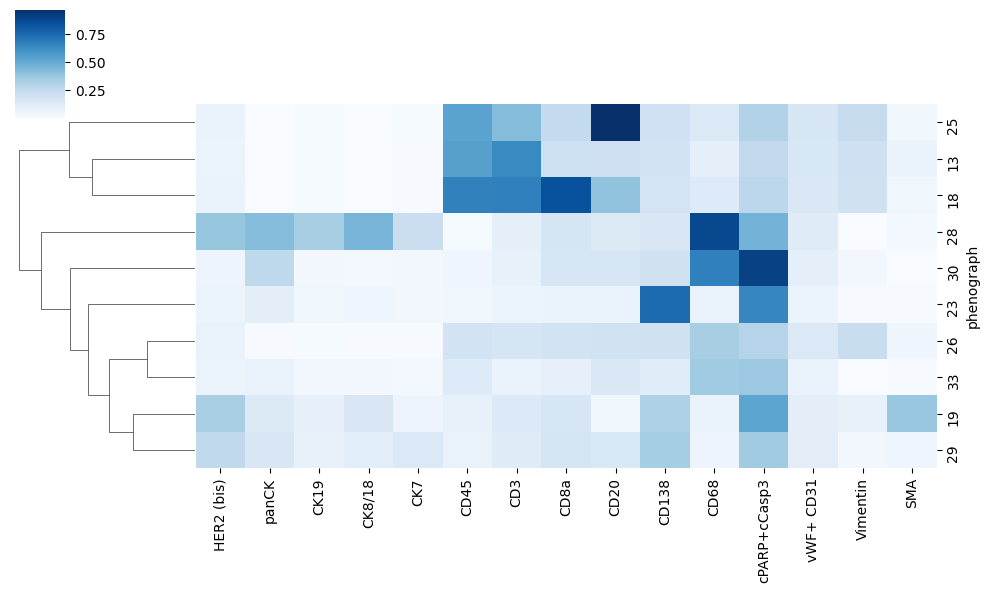

Cells per group (x 1,000):
phenograph
25    1.012
13    3.202
18    2.014
28    0.837
30    0.574
23    1.232
26    0.941
33    0.233
19    1.859
29    0.841
dtype: float64


In [56]:
## Custom plot
marker_subset = ct_markers
#marker_subset = np.concat([ct_markers, adata_recoded.var_names[[ x not in ct_markers for x in adata_recoded.var_names ]].to_numpy()]) ## all, but reordered
label_type = 'phenograph'
label_subset = [13,18,25, 28,30, 26,33, 19,23, 29] ## immune cells (but 28,30? 26,33?, 19,23?)
#label_subset = [35,1,11,12,6,3,4,5,7,34,20,37,31,2,32,19] ## cancer cells? (but 25,31,19,6,32?)
#label_subset = [8,22,27,9,14,24,29,26,33, 3,31, 16] ## low expression overall
figsize = (10,6)

df = pd.DataFrame( adata_recoded.X.copy() )
df.columns = adata_recoded.var_names
df[label_type] = adata_recoded.obs[label_type]

## Get number of cells per cluster
cell_counts = df.groupby(label_type, observed=False).size()

## Pivot table: get mean expression per 'phenograph' cluster
df = df.groupby(label_type, observed=False).mean()
df = df.loc[label_subset, marker_subset]

## Plot
## sns.clustermap cannot be used as subplot
## instead of plotting cell counts to the side, just print them
clmap = sns.clustermap(data=df, cmap='Blues', row_cluster=True, col_cluster=False,
                       figsize=figsize)
plt.show()

row_ind = clmap.dendrogram_row.reordered_ind ## get reordered row indices
print('Cells per group (x 1,000):')
print( cell_counts[ df.index[row_ind].values ] /1000 )

In [21]:
cancer_recoding['new_label'].value_counts()

new_label
1    73748
0      734
Name: count, dtype: int64

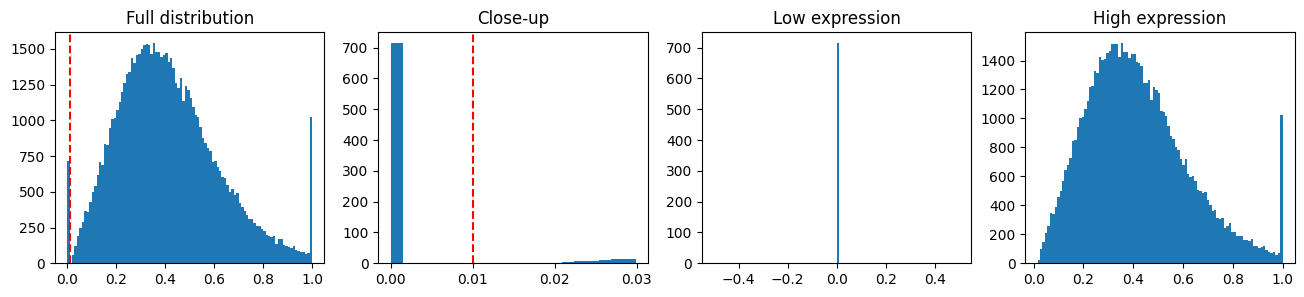

/tmp/ipykernel_6854/1217928430.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


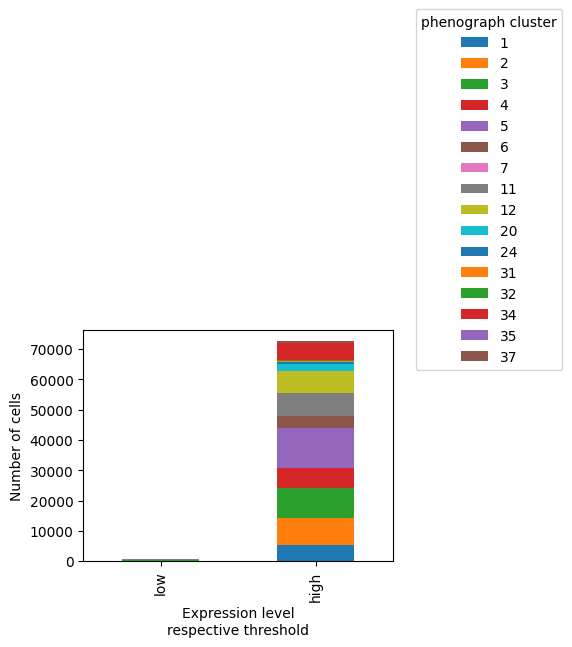

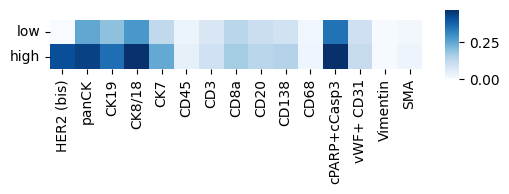

new_label
cancer cell        72596
epithelial cell      714
Name: count, dtype: int64

In [82]:
## Find cutoff value for cancer cells (HER2 if panCK+)
label_subset = [35,1,11,12,6,3,4,5,7,34,20,37,31,2,32,24]
marker = 'HER2 (bis)'
threshold = 0.01
interval=0.02

expr = adata_recoded.X[ adata_recoded.obs['phenograph'].isin(label_subset), adata_recoded.var_names==marker ]
phenograph_label = adata_recoded.obs['phenograph'][ adata_recoded.obs['phenograph'].isin(label_subset) ]
new_label = (expr>=threshold)*1 ## 0 if below threshold, 1 if >= threshold
cell_ids = adata_recoded.obs.loc[ adata_recoded.obs['phenograph'].isin(label_subset) , 'id' ]

## Plot original, close-up & resulting groups side by side
fig, ax = plt.subplots(1,4, figsize=(16,3))
ax[0].hist(expr, bins=100)
ax[0].axvline(x=threshold, color='r', linestyle='--')
ax[0].set_title('Full distribution')
ax[1].hist(expr[ (expr>=threshold-interval) & (expr<=threshold+interval) ], bins=20)
ax[1].axvline(x=threshold, color='r', linestyle='--')
ax[1].set_title('Close-up')
ax[2].hist(expr[ expr<threshold ], bins=100)
ax[2].set_title('Low expression')
ax[3].hist(expr[ expr>=threshold ], bins=100)
ax[3].set_title('High expression')
plt.show()

## Plot new groupings by original cluster
df = pd.DataFrame({'phenograph_label':phenograph_label,
                'new_label':new_label})
df = df.groupby(['new_label', 'phenograph_label'], observed=True).size().unstack().plot(kind='bar', stacked=True, figsize=(4,3))
plt.legend(bbox_to_anchor=(1.05, .8), loc='lower left', title='phenograph cluster')
plt.xticks(labels=['low', 'high'], ticks=[0,1])
plt.xlabel('Expression level\nrespective threshold')
plt.ylabel('Number of cells')
plt.tight_layout()
plt.show()

## Plot heatmap subset: new grouping, but more/all markers
expr_all = adata_recoded.X[ adata_recoded.obs['phenograph'].isin(label_subset), :]
expr_all0 = expr_all[ new_label==0, : ].mean(axis=0)
expr_all1 = expr_all[ new_label==1, : ].mean(axis=0)
df = pd.DataFrame([expr_all0, expr_all1], index=['low','high'], columns=adata_recoded.var_names)
df = df[marker_subset] ## comment in to show all markers

fig, ax = plt.subplots(figsize=(6,3))
sns.heatmap(ax=ax, data=df, square=True,
            cmap='Blues', cbar_kws={'shrink':.3, 'aspect':5}) #, 'location':'right', 'ticklocation':'right'})
plt.show()

## Create df for recoding
cancer_recoding = pd.DataFrame({'id':cell_ids,'new_label':new_label})
cancer_recoding['new_label'] = cancer_recoding['new_label'].map({0:'epithelial cell', 1:'cancer cell'})
cancer_recoding['new_label'].value_counts()

In [110]:
## Distinguish macrophages (CD68)
## Export all necessary information to temporary file
## to read into R to use FlowSOM for clustering

outfile = "../../data/temp/Kuett_2022_reclustering_macrophages.csv"
label_subset = [28,30,33,26]

idx = adata_recoded.obs['phenograph'].isin(label_subset)
pd.concat([ pd.DataFrame({'id':adata_recoded.obs['id'][idx],
                          'phenograph':adata_recoded.obs['phenograph'][idx]}).reset_index(drop=True),
            pd.DataFrame(adata_recoded.X[idx, :], columns=adata_recoded.var_names) ],
            axis=1) .to_csv(outfile, index=False)

flowsom
unassigned                         1142
macrophage HER2/panCK/Cadherin+     839
macrophage cPARP/cCASP3+            312
macrophage CD44+                    292
Name: count, dtype: int64


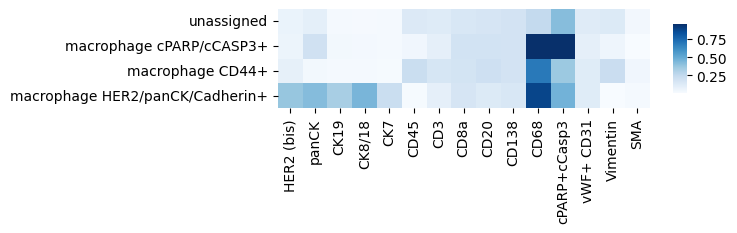

In [46]:
## Get macrophage flowsom clusters
infile = "../../data/temp/Kuett_2022_reclustering_macrophages_flowsom.csv"
macrophage_recoding = pd.read_csv(infile)
macrophage_recoding['flowsom'] = macrophage_recoding['flowsom'].map({'group_1':'macrophage cPARP/cCASP3+',
                                                                    'group_2':'macrophage CD44+',
                                                                    'group_3':'macrophage HER2/panCK/Cadherin+',
                                                                    'unassigned':'unassigned'})
print(macrophage_recoding['flowsom'].value_counts())

## Plot heatmap subset: new grouping, but more/all markers
idx = adata_recoded.obs.reset_index(names='idx').set_index('id').loc[macrophage_recoding['id'], :].reset_index()['idx']
expr_all = adata_recoded.X[idx, :]
expr_all0 = expr_all[ macrophage_recoding['flowsom']=='unassigned', : ].mean(axis=0)
expr_all1 = expr_all[ macrophage_recoding['flowsom']=='macrophage cPARP/cCASP3+', : ].mean(axis=0)
expr_all2 = expr_all[ macrophage_recoding['flowsom']=='macrophage CD44+', : ].mean(axis=0)
expr_all3 = expr_all[ macrophage_recoding['flowsom']=='macrophage HER2/panCK/Cadherin+', : ].mean(axis=0)
df = pd.DataFrame([expr_all0, expr_all1, expr_all2, expr_all3],
                  index=['unassigned', 'macrophage cPARP/cCASP3+', 'macrophage CD44+', 'macrophage HER2/panCK/Cadherin+'],
                  columns=adata_recoded.var_names)
df = df[marker_subset] ## comment in to show all markers

fig, ax = plt.subplots(figsize=(6,3))
sns.heatmap(ax=ax, data=df, square=True,
            cmap='Blues', cbar_kws={'shrink':.3, 'aspect':5}) #, 'location':'right', 'ticklocation':'right'})
plt.show()

In [57]:
## Distinguish plasma cells (CD138)
## Export all necessary information to temporary file
## to read into R to use FlowSOM for clustering

outfile = "../../data/temp/Kuett_2022_reclustering_plasmacells.csv"
label_subset = [19,23,29]

idx = adata_recoded.obs['phenograph'].isin(label_subset)
pd.concat([ pd.DataFrame({'id':adata_recoded.obs['id'][idx],
                          'phenograph':adata_recoded.obs['phenograph'][idx]}).reset_index(drop=True),
            pd.DataFrame(adata_recoded.X[idx, :], columns=adata_recoded.var_names) ],
            axis=1) .to_csv(outfile, index=False)

flowsom
unassigned     3121
plasma cell     811
Name: count, dtype: int64


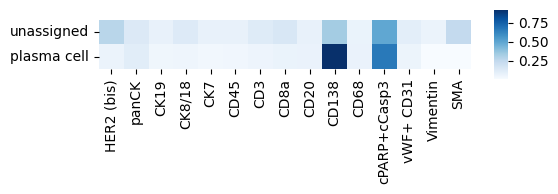

In [58]:
## Get plasma cell flowsom clusters
infile = "../../data/temp/Kuett_2022_reclustering_plasmacells_flowsom.csv"
plasmacell_recoding = pd.read_csv(infile)
plasmacell_recoding['flowsom'] = plasmacell_recoding['flowsom'].map({'group_1':'plasma cell',
                                                                    'unassigned':'unassigned'})
print(plasmacell_recoding['flowsom'].value_counts())

## Plot heatmap subset: new grouping, but more/all markers
idx = adata_recoded.obs.reset_index(names='idx').set_index('id').loc[plasmacell_recoding['id'], :].reset_index()['idx']
expr_all = adata_recoded.X[idx, :]
expr_all0 = expr_all[ plasmacell_recoding['flowsom']=='unassigned', : ].mean(axis=0)
expr_all1 = expr_all[ plasmacell_recoding['flowsom']=='plasma cell', : ].mean(axis=0)
df = pd.DataFrame([expr_all0, expr_all1],
                  index=['unassigned', 'plasma cell'],
                  columns=adata_recoded.var_names)
df = df[marker_subset] ## comment in to show all markers

fig, ax = plt.subplots(figsize=(6,3))
sns.heatmap(ax=ax, data=df, square=True,
            cmap='Blues', cbar_kws={'shrink':.3, 'aspect':5}) #, 'location':'right', 'ticklocation':'right'})
plt.show()

In [83]:
## Assign cell types
# Recode all phenograph clusters that are assigned without reclustering
label2description = {-1: "other",
                    1: "",
                    2: "",
                    3: "",
                    4: "",
                    5: "",
                    6: "",
                    7: "",
                    8: "other",
                    9: "other",
                    #10: "", ## not present
                    11: "",
                    12: "",
                    13: "CD8- T cell", ## also in Kuett et al. (as 'T')
                    14: "stromal cell",
                    15: "myofibroblast",
                    16: "other",
                    17:'myofibroblast',
                    18: "CD8+ T cell", ## also in Kuett et al. (as 'T')
                    19: "",
                    20: "",
                    21: "endothelial cell", ## also in Kuett et al.
                    22:'stromal cell',
                    23: "",
                    24: "",
                    25:'B cell',
                    26: "",
                    27: "stromal cell",
                    28: "", ## in Kuett et al.: macrophage
                    29: "",
                    30:'', ## in Kuett et al.: macrophage
                    31: "",
                    32: "",
                    33: "",
                    34: "",
                    35: "",
                    36: "apoptotic cell",
                    37: ""}
adata_recoded.obs['ct_broad'] = adata_recoded.obs['phenograph'].map(label2description).astype('category')

## Recode all cells that were reclustered
adata_recoded.obs['ct_broad'] = adata_recoded.obs['ct_broad'].astype(str) ## to add new categories
for ct in cancer_recoding['new_label'].unique():
    ids_to_update = cancer_recoding.loc[cancer_recoding['new_label'] == ct, 'id']
    adata_recoded.obs.loc[adata_recoded.obs['id'].isin(ids_to_update), 'ct_broad'] = ct
for df in [macrophage_recoding, plasmacell_recoding]:
    for ct in df['flowsom'].unique():
        ids_to_update = df.loc[df['flowsom'] == ct, 'id']
        adata_recoded.obs.loc[adata_recoded.obs['id'].isin(ids_to_update), 'ct_broad'] = ct
adata_recoded.obs.loc[ adata_recoded.obs['ct_broad']=='unassigned', 'ct_broad' ] = 'other'
adata_recoded.obs['ct_broad'] = adata_recoded.obs['ct_broad'].astype('category')

adata_recoded.obs['ct_broad'].value_counts() / 1000 ## in thousands for readability

ct_broad
cancer cell                        72.596
other                              15.268
stromal cell                        5.981
myofibroblast                       3.713
CD8- T cell                         3.202
CD8+ T cell                         2.014
endothelial cell                    1.663
B cell                              1.012
macrophage HER2/panCK/Cadherin+     0.839
plasma cell                         0.811
epithelial cell                     0.714
macrophage cPARP/cCASP3+            0.312
macrophage CD44+                    0.292
apoptotic cell                      0.069
Name: count, dtype: float64

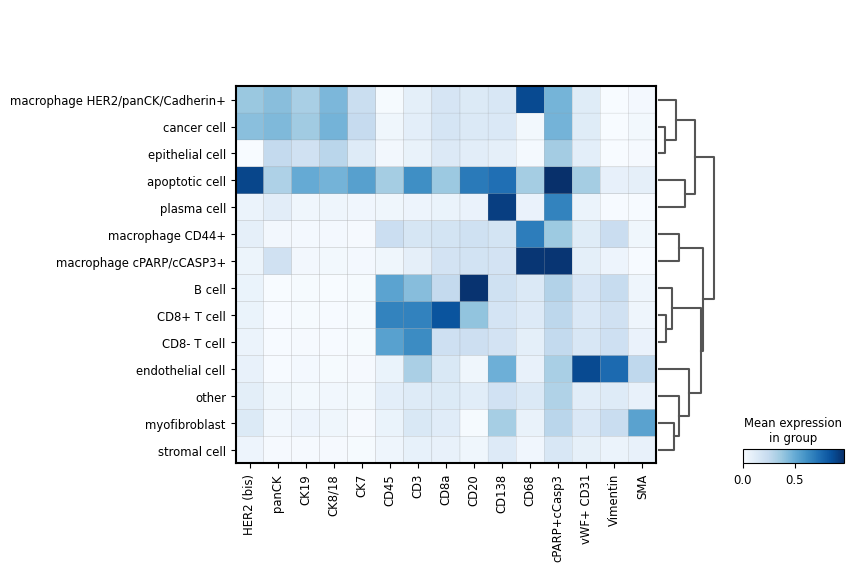

In [84]:
## Plot heatmap with new cell type labels
sc.tl.dendrogram(adata_recoded, groupby='ct_broad')
sc.pl.matrixplot(adata=adata_recoded,
                var_names=ct_markers,
                groupby='ct_broad',
                dendrogram=True, cmap='Blues')

Notes about clustering:
- -1: According to the [phenograph documentation](https://github.com/jacoblevine/PhenoGraph), "Any rows assigned -1 were identified as outliers and should not be considered as a member of any community"
- 16: Notably low expression on all markers. No phenotype assigned ("other")

Missing/unclear, but expected cell types
- healthy epithelial cells
- macrophages (see below)
- plasma cells (see below)

Unclear clusters: important:
- 35: maybe cancer?; high CD8a (T cell, but w/o CD45 & CD3)
- 23, 19 (29): maybe plasma cell? but not CD45+
- 28, 30 (33, 26): maybe MO? but not CD45+

Unclear clusters: less important:
- 31: maybe cancer?; high Ki67 (proliferation)
- 19: maybe cancer?; high CK5 (basal marker)
- 6: maybe cancer?; high phospho-H3
- 32: maybe cancer?; high pS6
- 8: ?, high pS6
- 22 (27, 14): stromal?; low expression but high(er) collagen
- 9: low expression overall

In [85]:
## Save to file
outfile = input_base + 'model201710_cluster_labels_phenograph_recoded.csv'

#adata_recoded.obs.rename({'cell_labels':'id'}, axis='columns', inplace=True)
adata_recoded.obs[['id', 'phenograph', 'ct_broad']].to_csv(outfile, index=False)

In [7]:
## Load data if previously saved
infile = input_base + 'model201710_cluster_labels_phenograph_recoded.csv'

df = pd.read_csv(infile)
df = adata.obs.merge(df, left_on='cell_labels', right_on='id')[['id', 'phenograph', 'ct_broad']]
adata_recoded = adata.copy()
adata_recoded.obs = df
adata_recoded

AnnData object with n_obs × n_vars = 108486 × 25
    obs: 'id', 'phenograph', 'ct_broad'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

In [1]:
## Save environment/requirements file
import os

os.system("""
    pip freeze > ../../requirements/phenotyping.txt
""")

0